# Social Media Activity Recognition
The goal is to develop a machine learning pipeline to recognize different social media usage using an iPhone’s motion sensors (accelerometer, gyroscope, etc).

#### Activities
1. Instagram
2. Tinder
3. Facebook
4. LinkedIn
5. Notetaking/texting

### Importing libraries

In [1]:
# essentials
import numpy as np # used for handling numbers
import scipy as sc
import pandas as pd # used for handling the dataset
import os # to get csv files of data

from sklearn.model_selection import KFold, GroupKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.preprocessing import StandardScaler # used for feature scaling

# classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# neural networks
import tensorflow as t # for RNN

# preprocessing
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer

# analysis
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## Loads the sensor data from numpy files.
### First, manually filter each CSV to remove any rows where Light > 100, to ensure that the data is only from when phone was in pocket.

In [2]:
def load_data(base_folder, activity, convert_to_numpy=True):
    out = []
    file_names = os.listdir('%s/%s' %(base_folder, activity))
    for file in file_names:
        if (file == '.DS_Store'):
            continue
        data = pd.read_csv(('%s/%s/'+file) % (base_folder, activity),
                            usecols=[
                                    'loggingTime(txt)',
                                    'loggingSample(N)', # this is easier to filter beginning/end frames
                                    'locationLatitude(WGS84)',
                                    'locationLongitude(WGS84)',
                                    'locationAltitude(m)',
                                    'locationSpeed(m/s)',
#                                     'locationCourse(¬∞)',
#                                     'locationHeadingX(¬µT)',
#                                     'locationHeadingY(¬µT)',
#                                     'locationHeadingZ(¬µT)',
#                                     'locationTrueHeading(¬∞)',
#                                     'locationMagneticHeading(¬∞)',
                                    'accelerometerAccelerationX(G)',
                                    'accelerometerAccelerationY(G)',
                                    'accelerometerAccelerationZ(G)',
                                    'gyroRotationX(rad/s)',
                                    'gyroRotationY(rad/s)',
                                    'gyroRotationZ(rad/s)',
#                                     'magnetometerX(¬µT)',
#                                     'magnetometerY(¬µT)',
#                                     'magnetometerZ(¬µT)',
                                    'motionYaw(rad)',
                                    'motionRoll(rad)',
                                    'motionPitch(rad)',
                                    'motionRotationRateX(rad/s)',
                                    'motionRotationRateY(rad/s)',
                                    'motionRotationRateZ(rad/s)',
                                    'motionUserAccelerationX(G)',
                                    'motionUserAccelerationY(G)',
                                    'motionUserAccelerationZ(G)',
                                    'motionQuaternionX(R)',
                                    'motionQuaternionY(R)',
                                    'motionQuaternionZ(R)',
                                    'motionQuaternionW(R)',
                                    'motionGravityX(G)',
                                    'motionGravityY(G)',
                                    'motionGravityZ(G)',
#                                     'motionMagneticFieldX(¬µT)',
#                                     'motionMagneticFieldY(¬µT)',
#                                     'motionMagneticFieldZ(¬µT)',
                                    'altimeterRelativeAltitude(m)',
                                    'altimeterPressure(kPa)',
                                    'deviceOrientation(Z)',
                                    'avAudioRecorderPeakPower(dB)',
                                    'avAudioRecorderAveragePower(dB)']
                          )
        data = filter_input(data)
        
        if convert_to_numpy:
            out.append(data.to_numpy())
        else:
            out.append(data)
    return out

### Pre-processing

In [3]:
# This particular cell of code was taken from:
# https://github.com/KChen89/Accelerometer-Filtering/blob/master/acc.py
#
# This does median filtering to reduce noise for acc. and gyro data
# Ignore this unless u want to understand implementation of plotting commented out in the next cell
import math
from scipy.fftpack import fft
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

# creates a median filter on data
def median_filter(data, f_size):
    lgth, num_signal=data.shape
    f_data=np.zeros([lgth, num_signal])
    
    for i in range(num_signal):
        f_data[:,i]=signal.medfilt(data[:,i], f_size)
    return f_data

# creates a frequency filter on data
def freq_filter(data, f_size, cutoff):
    lgth, num_signal=data.shape
    f_data=np.zeros([lgth, num_signal])
    lpf=signal.firwin(f_size, cutoff, window='hamming')
    for i in range(num_signal):
        f_data[:,i]=signal.convolve(data[:,i], lpf, mode='same')
    return f_data

# creates a fast fourier transform plot on data
def fft_plot(data, fs, title):
    lgth, num_signal=data.shape
    fqy=np.zeros([lgth,num_signal])
    fqy[:,0]=np.abs(fft(data[:,0]))
    fqy[:,1]=np.abs(fft(data[:,1]))
    fqy[:,2]=np.abs(fft(data[:,2]))
    index=np.arange(int(lgth/2))/(int(lgth/2)/(fs/2))
    
    fig, ax=plt.subplots()
    labels=['x','y','z']
    color_map=['r', 'g', 'b']
    for i in range(3):
        ax.plot(index, fqy[0:int(lgth/2),i], color_map[i], label=labels[i])
    ax.set_xlim([0, fs/2])
    ax.set_xlabel('Hz')
    ax.set_title('Frequency spectrum: '+title) 
    ax.legend()

# plots lines! Wooo
def plot_lines(data, fs, title):
    num_rows, num_cols=data.shape
    if num_cols!=3:
        raise ValueError('Not 3D data')
        
    fig, ax=plt.subplots()
    labels=['x','y','z']
    color_map=['r', 'g', 'b']
    index=np.arange(num_rows)/fs
    
    for i in range(num_cols):
        ax.plot(index, data[:,i], color_map[i], label=labels[i])
    ax.set_xlim([0,num_rows/fs])
    ax.set_xlabel('Time [sec]')
    ax.set_title('Time domain: '+title)
    ax.legend()

# creates the 3D plot of our accelerometer/gyroscope data
def plot3D(data, title):
    fig=plt.figure()
    ax=fig.add_subplot(111, projection='3d')
    ax.plot(xs=data[:,0], ys=data[:,1], zs=data[:,2], zdir='z')
    ax.set_title(title)

Be careful not to run the plots when loading all the data. Test it by loading just a file or group of files and uncomment after finished exploring.

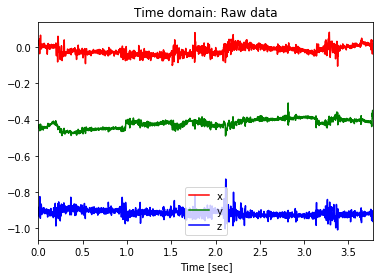

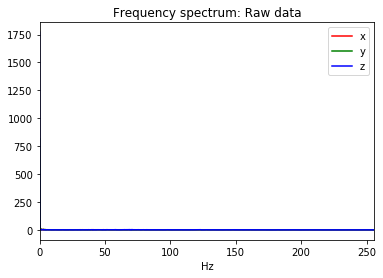

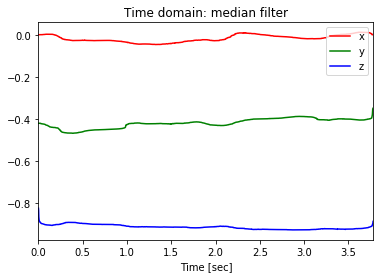

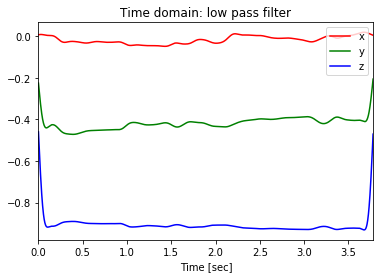

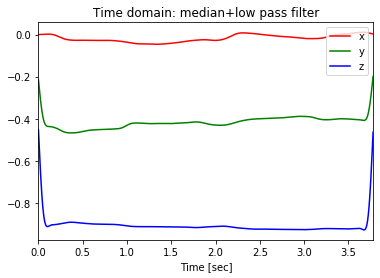

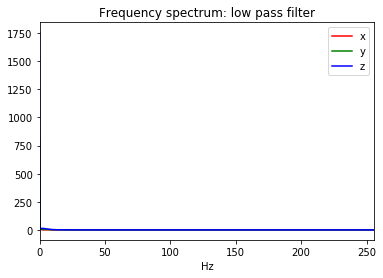

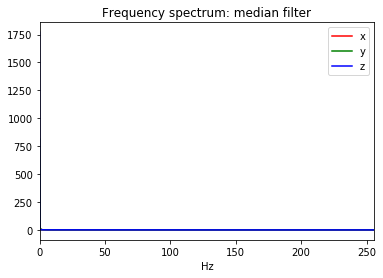

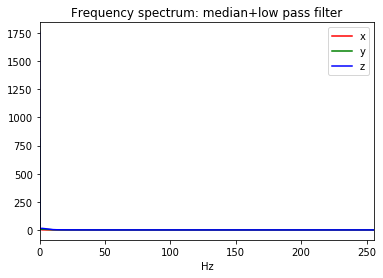

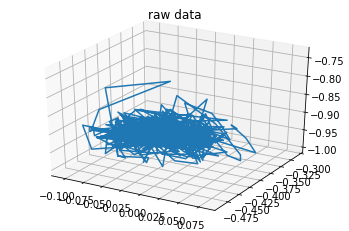

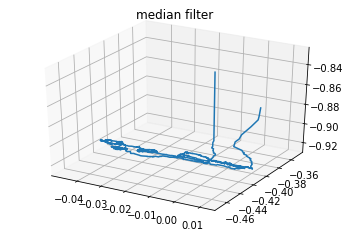

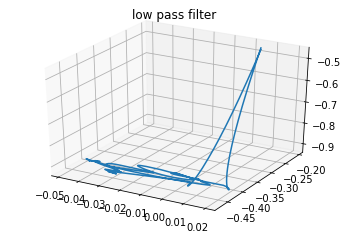

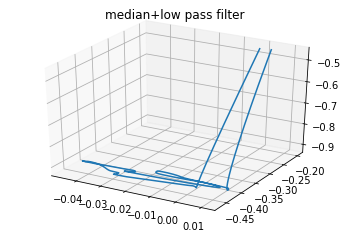

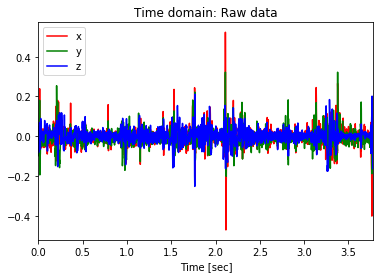

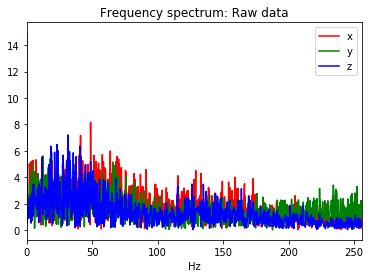

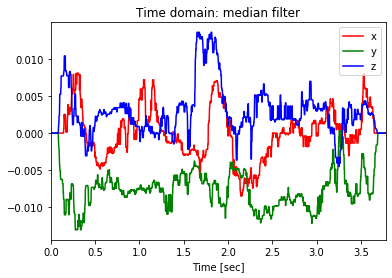

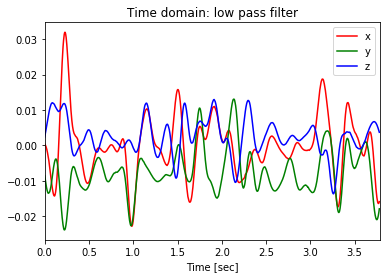

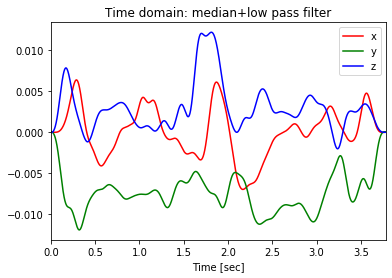

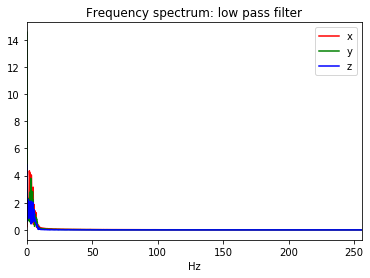

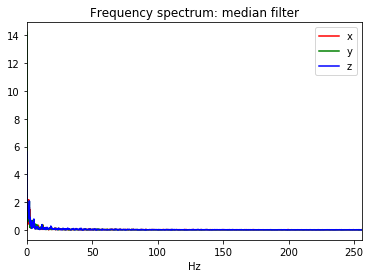

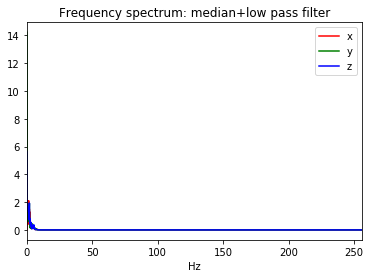

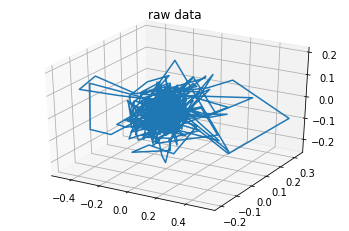

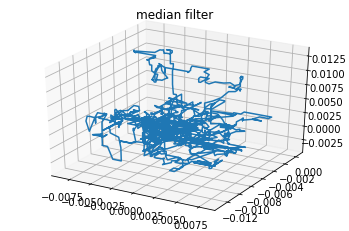

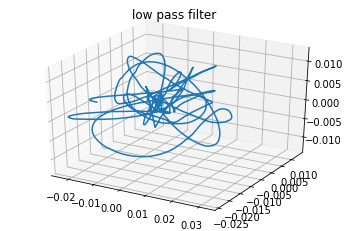

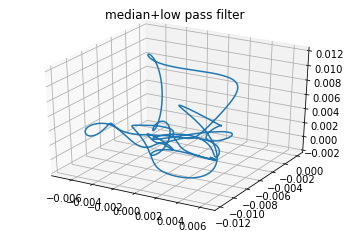

In [20]:
# filters accelerometer or gyroscope data
cutoff=10
fs=512
def filter_sensor(data, sensor_type):
    if sensor_type == "gyroscope":
        sensor_data = data.iloc[:,9:12].to_numpy()
    else:
        sensor_data = data.iloc[:,6:9].to_numpy()
    
#     median_data=median_filter(sensor_data, 155)
    lpf_data=freq_filter(sensor_data, 155, cutoff/fs)
#     comb_data=freq_filter(median_data, 155, cutoff/fs)
    
#     plot_lines(sensor_data, fs, 'Raw data')
#     fft_plot(sensor_data, fs, 'Raw data')
    
#     plot_lines(median_data, fs, 'median filter')
#     plot_lines(lpf_data, fs, 'low pass filter')
#     plot_lines(comb_data, fs, 'median+low pass filter')
    
#     fft_plot(lpf_data, fs, 'low pass filter')
#     fft_plot(median_data, fs, 'median filter')
#     fft_plot(comb_data, fs, 'median+low pass filter')
    
#     plot3D(sensor_data, 'raw data')
#     plot3D(median_data, 'median filter')
#     plot3D(lpf_data, 'low pass filter')
#     plot3D(comb_data, 'median+low pass filter')
#     plt.show()
    
    if sensor_type == "gyroscope":
        data.loc[:,'gyroRotationX(rad/s)'] = lpf_data[:,0]
        data.loc[:,'gyroRotationY(rad/s)'] = lpf_data[:,1]
        data.loc[:,'gyroRotationZ(rad/s)'] = lpf_data[:,2]
    else:
        data.loc[:,'accelerometerAccelerationX(G)'] = lpf_data[:,0]
        data.loc[:,'accelerometerAccelerationY(G)'] = lpf_data[:,1]
        data.loc[:,'accelerometerAccelerationZ(G)'] = lpf_data[:,2]
    return data

# X_tinder = load_data("samples", "facebook")

In [5]:
# Delete the first 2 seconds (60 rows), and last 1 second (30 rows)
def filter_input(data):
    data = data.iloc[60:-60,]
    data = filter_sensor(data, "accelerometer")
    data = filter_sensor(data, "gyroscope")
    return data

Actually load the data

In [6]:
# Load the data for each class
X_tinder = load_data("data", "tinder")
X_instagram = load_data("data", "instagram")
X_notes = load_data("data", "notes")
X_facebook = load_data("data", "facebook")
X_linkedin = load_data("data", "linkedin")

# Assigning groundtruth conditions to each class
Y_tinder = [0] * len(X_tinder) 
Y_instagram = [1] * len(X_instagram)
Y_notes = [2] * len(X_notes)
Y_facebook = [3] * len(X_facebook)
Y_linkedin = [4] * len(X_linkedin)

X = np.concatenate((X_tinder, X_instagram, X_notes, X_facebook, X_linkedin)) # insert standing when done 
Y = np.concatenate((Y_tinder, Y_instagram, Y_notes, Y_facebook, Y_linkedin)) # insert standing when done
print("Total number of X samples: " + str(len(X)))
print("Total number of Y samples: " + str(len(Y)))

/Users/bennetthuffman/.local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Total number of X samples: 167
Total number of Y samples: 167


In [7]:
column_name = 'motionPitch(rad)' # replace me with other sensors!
activities = ['facebook', 'instagram', 'linkedin', 'notes', 'tinder']

for a in activities:
    curr_data = load_data('samples', a, False)[0]
    print(a)
    print(curr_data[column_name].describe())
    print('')
    
#     'accelerometerAccelerationX(G)',
#     'accelerometerAccelerationY(G)',
#     'accelerometerAccelerationZ(G)',
#     'gyroRotationX(rad/s)',
#     'gyroRotationY(rad/s)',
#     'gyroRotationZ(rad/s)',
#     'motionYaw(rad)',
#     'motionRoll(rad)',
#     'motionPitch(rad)',
#     'motionRotationRateX(rad/s)',
#     'motionRotationRateY(rad/s)',
#     'motionRotationRateZ(rad/s)',
#     'motionUserAccelerationX(G)',
#     'motionUserAccelerationY(G)',
#     'motionUserAccelerationZ(G)',
#     'motionQuaternionX(R)',
#     'motionQuaternionY(R)',
#     'motionQuaternionZ(R)',
#     'motionQuaternionW(R)',
#     'motionGravityX(G)',
#     'motionGravityY(G)',
#     'motionGravityZ(G)',

facebook
count    1936.000000
mean        0.434090
std         0.025280
min         0.379947
25%         0.413376
50%         0.430085
75%         0.450800
max         0.495081
Name: motionPitch(rad), dtype: float64

instagram
count    1644.000000
mean        0.670083
std         0.087409
min         0.282256
25%         0.647026
50%         0.661296
75%         0.718457
max         1.000684
Name: motionPitch(rad), dtype: float64

linkedin
count    1512.000000
mean        0.566341
std         0.083944
min         0.412432
25%         0.501860
50%         0.566077
75%         0.617322
max         1.013837
Name: motionPitch(rad), dtype: float64

notes
count    1654.000000
mean        0.819122
std         0.057150
min         0.619680
25%         0.780668
50%         0.828112
75%         0.855144
max         0.971548
Name: motionPitch(rad), dtype: float64

tinder
count    1901.000000
mean        0.285155
std         0.048023
min         0.150253
25%         0.250699
50%         0.286083
7

## Featurization

In [8]:
# calculate the norm/magnitude of a 3-axis sensor
def calc_sensor_norm(sensor_x, sensor_y, sensor_z):
    sensor_total = []
    for i in range(len(sensor_x)):
        sensor_total.append((sensor_x[i]**2 + sensor_y[i]**2 + sensor_z[i]**2)**5)
    return sensor_total

# window input data by seconds and overlap
def window_input(input_data, seconds=1, overlap=0.5, hz=30):
    data_len = len(input_data)
    window_len = seconds*hz
    overlap_len = int(window_len * (1-overlap))
    frame_count = 0
    windows, next_win = [], []
    # create windows if fits; up to overlap_len - 1 frames removed from end
    for i in range(data_len):
        next_win.append(input_data[i])
        frame_count += 1
        if (frame_count % overlap_len == 0) and (len(next_win) == window_len):
            windows.append(next_win.copy())
            del next_win[:overlap_len]
    windows = np.asarray(windows)
    return np.asarray(windows)

# create spectrogram data. If windowing, calculate FFT at 50% overlap; else use whole recording
def process_input(X, Y, windowing):
    x_out = []
    y_out = []
    groups = list([])
    for i in range(len(X)):
        if windowing:
            windows = window_input(X[i], 2, 0.5, 30)
            # featurize and add to output
            for w in windows:
                groups.append(i)
                a_feat = featurize_input(w)
                x_out.append(a_feat)
                y_out.append(Y[i])
        else:
            groups.append(i)
            w = featurize_input(X[i])
            x_out.append(w)
            y_out.append(Y[i])
    return (np.asarray(x_out), np.asarray(y_out), np.asarray(groups))

# Add bins as features or domain-specific features
def featurize_input(sample):
    fv = []
    acc_x = sample[:,6]
    acc_y = sample[:,7]
    acc_z = sample[:,8]
    acc_total = calc_sensor_norm(acc_x, acc_y, acc_z)
    gyro_x = sample[:,9]
    gyro_y = sample[:,10]
    gyro_z = sample[:,11]
    gyro_total = calc_sensor_norm(gyro_x, gyro_y, gyro_z)
    loc_speed = sample[:,5]
    altimeter = sample[:,28]
    
    motionYaw = sample[:,12]
    fv.append(np.max(motionYaw))
    fv.append(np.mean(motionYaw))
    fv.append(np.std(motionYaw))
    motionRoll = sample[:,13]
    fv.append(np.max(motionRoll))
    fv.append(np.mean(motionRoll))
    fv.append(np.std(motionRoll))
    motionPitch = sample[:,14]
    fv.append(np.min(motionPitch))
    motionRotationRateX = sample[:,15]
    motionRotationRateY = sample[:,16]
    motionRotationRateZ = sample[:,17]
    
#     'motionYaw(rad)',
#     'motionRoll(rad)',
#     'motionPitch(rad)',
#     'motionRotationRateX(rad/s)',
#     'motionRotationRateY(rad/s)',
#     'motionRotationRateZ(rad/s)',
#     'motionUserAccelerationX(G)',
#     'motionUserAccelerationY(G)',
#     'motionUserAccelerationZ(G)',
    
    fv = []
    sample = np.asarray(acc_total)

    # extremes
    fv.append(np.max(acc_total))
    fv.append(np.max(gyro_total))
    fv.append(np.max(loc_speed))
    fv.append(np.max(altimeter))
    
    # I noticed this helps w/ differentiating climbing
    fv.append(np.max(gyro_x))
    fv.append(np.max(gyro_y))
    fv.append(np.max(gyro_z))

    # averages
    fv.append(np.mean(acc_total))
    fv.append(np.mean(gyro_total))
    fv.append(np.mean(loc_speed))
    fv.append(np.mean(acc_x))
    fv.append(np.mean(acc_y))
    fv.append(np.mean(acc_z))
    fv.append(np.mean(gyro_x))
    fv.append(np.mean(gyro_y))
    fv.append(np.mean(gyro_z))
    
    fv.append(np.median(acc_total))
    fv.append(np.median(gyro_total))
    fv.append(np.median(loc_speed))
    

    # deviation
    fv.append(np.std(acc_total))
    fv.append(np.std(gyro_total))
    fv.append(np.std(loc_speed))
    fv.append(np.std(altimeter))
    
    # Peak-to-peak
    # Rootmean-square
    # Correlation between values of accelerometer and gyroscope axes are extracted
    
    fv = np.asarray(fv)
    return fv

## Choose if featuring

In [9]:
windowing = True
X_processed, Y_adjusted, groups = process_input(X, Y, windowing)
print(X_processed.shape)
print(Y_adjusted.shape)

(11394, 23)
(11394,)


## Normalize

23


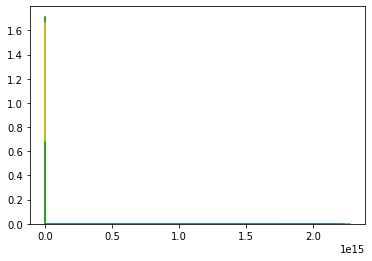

In [10]:
scaler = RobustScaler()
X = scaler.fit_transform(X_processed) # this normalizes well
import seaborn as sns
print(X.shape[1])
for i in range(X.shape[1]):
    sns.kdeplot(X[:,i])

## Setting up the variables to run the classifier

In [11]:
kkn_clf = KNeighborsClassifier()
nb_clf = GaussianNB()
randf_clf = RandomForestClassifier()
mlp_clf = MLPClassifier()
logr_clf = LogisticRegression()
svm_clf = SVC(gamma='auto', kernel='rbf')

# pick one
clf = RandomForestClassifier(warm_start=True)
# clf = RandomForestClassifier(n_estimators=100)

## Cross-validation

In [12]:
scores = []

if windowing:
    cv = GroupKFold(n_splits=10)
else:
    cv = KFold(n_splits=10, random_state=42, shuffle=True)

## Calculate model accuracy

In [13]:
# print(Y_adjusted) # y values, 0-5
# print(groups) # group values, 0-119

if windowing:
    for train_index, test_index in cv.split(X, Y_adjusted, groups):
#         print("Train Index: ", train_index)
#         print("Test Index: ", test_index)
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y_adjusted[train_index], Y_adjusted[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
else:
    for train_index, test_index in cv.split(X):
#         print("Train Index: ", train_index)
#         print("Test Index: ", test_index)
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y_adjusted[train_index], Y_adjusted[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))

print("Mean accuracy:" + str(np.mean(scores)))

Mean accuracy:0.8057883566661698


## Investigate decision boundaries and spread of data

In [14]:
#Give index of features that you are interested in looking at
# mean, std, median, min, max, 
sub_features = [0,1]

In [15]:
# h = .2  # step size in the mesh
# x_min, x_max = X[:, 2].min() - .5, X[:, 2].max() + .5
# y_min, y_max = X[:, 3].min() - .5, X[:, 3].max() + .5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))
# h = .2  # step size in the mesh
# x_min, x_max = X[:, sub_features[0]].min() - .5, X[:, sub_features[0]].max() + .5
# y_min, y_max = X[:, sub_features[1]].min() - .5, X[:, sub_features[1]].max() + .5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))

# cm = plt.cm.RdBu
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# # Plot the training points
# clf.fit(X_train[:,sub_features],y_train)
# scores.append(clf.score(X_test[:,sub_features], y_test))
# print('Mean Accuracy : ',str(np.mean(scores)))
# print('This accuracy number is not used for evaluating your solution as it only looks at a subset of features.')

## Confusion matrix

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [17]:
# https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
true_y = []
pred_y = []

if windowing:
    for train_index, test_index in cv.split(X, Y_adjusted, groups):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y_adjusted[train_index], Y_adjusted[test_index]
        
        # get predictions
        predictions = clf.fit(X_train, y_train).predict(X_test)
        pred_y.extend(predictions)
        true_y.extend(y_test)
else:
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], Y_adjusted[train_index], Y_adjusted[test_index]
        
        # get predictions
        predictions = clf.fit(X_train, y_train).predict(X_test)
        pred_y.extend(predictions)
        true_y.extend(y_test)

Normalized confusion matrix
[[0.82 0.02 0.05 0.09 0.03]
 [0.08 0.78 0.04 0.03 0.08]
 [0.07 0.08 0.76 0.07 0.02]
 [0.06 0.03 0.02 0.85 0.04]
 [0.05 0.05 0.01 0.06 0.83]]


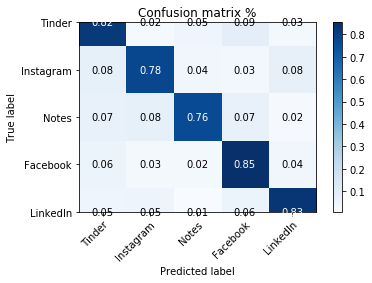

In [18]:
# true y vs predicted y
class_names = np.asarray(["Tinder", "Instagram", "Notes", "Facebook", "LinkedIn"])
plot_confusion_matrix(true_y, pred_y, classes=class_names, normalize=True,
                      title='Confusion matrix %')

## Writeup
### Data collection
Data was recorded all using an iPhone X after facing problems with consistent rates between both Android and iOS recordings. Data was recorded with the participation of over 12 individuals over the course of one month using each platform on iOS who have experience using each platform to account for variability. All participants are Carnegie Mellon University undergraduate students. However, most data was generated by two individuals due to time constraints and recruitment over holidays. We tested on five different social media platforms: 

1. Instagram
2. Tinder
3. Facebook
4. LinkedIn
5. Notetaking/texting

Samples for activity on each social media platform are approximately between 30-60 seconds long. Subjects were told to use the platforms as they normally would, and were instructed when to start and stop recordings. It is worth noting no data was collected while traveling.

### Pre-processing
Recordings were sampled at 30Hz, with sensor data including location, acceleromter, gyroscope, magnetometer, motion and rotation, and altimeter amongst other miscellaneous data. I removed unnecessary metadata from the dataset. Generally speaking, there was a brief switchover time of 1-2 seconds when users flipped between the sensor app and  social media platform. We removed two seconds from the beginning and end of each recording to ensure all data collected was exclusively the activity taking place.

We tried multiple methods to pre-process the data, including a low-pass filter, median filter, and combination of both to reduce the noise. There was no significant difference in accuracy with the combination of both, and the low-pass filter performed better. Windowing was similar. Activity recognition was siginficantly better when windowing in general, but window sizes of 1s, 1.5s, 2s, 2.5s, 3s, 3.5s, and 4s with 50% overlap showed no significant differences. Because user actions on each platform likely don't change much, this was a somewhat effective way to increase the amount of data available. Windowing is also much better for implementing our program in real-time.

### Feature extraction
We started by extracting typical features after exploratory data anlysis and plotting of the different social media platforms. The common features include extremes, averages, and variance such as standard deviation. Calculated features include the norm of 3-axis sensors, rootmean-square, peak-to-peak, and correlation between accelerometer and gyroscope data.

Domain-specific features for accelerometer and gyroscope data:
1. Extremes (max, min)
2. Averages (mean, median)
3. Variance (st. deviation, rootmean-square, peak-to-peak)
4. Correlation (acc. & gyro)
5. ???
6. Profit

### Feature selection
Because of finding success in activity recognition fo A4, we used 
I first attempted to run through the data using extremes, averages, and variance on only the accelerometer and gyroscope data using a SVM classifier with a rbf kernel. I surprisingly received good results, but the confusion matrix made clear walking was often confused with climbing up or down. I hand-picked features empirically by examining these basic statistics and found the location speed and altimeter to help differentiate the classes (for somewhat obvious reasons!). After receiving about 96% accuracy, I tested the data with windowing and saw climbing up and down were often confounded. I addressed this by selecting the accelerometer/gyroscope features on X, Y, and Z instead of just their norms. Other features might further differentiate the two. I saw decent improvements in the cofnusion matrix.


### Classification
Because the SVM classifier performed well and many features were easily extractable and understandable, I decided not to use deep learning despite CNNs appearing to be common in activity recognition tasks. I initially had 92% accuracy with the SVM on just accelerometer and gyroscope data. I then proceeded to test other classifiers identified in research papers for this task, including MLP and kNN. K-Nearest Neighbors performed extremely well, bumping accuracy from 92% to 95%. After using windowing, accuracy went down significantly. I then tested with a decision tree classifier and random forest. These algorithms significantly improved results, with Random Forest resulting in over 97% accuracy.

Because it had the ideal solution of windowing and 97% accuracy, I settled with this classifier.

### Conclusion
Activity recognition can always be improved. Given so many sensor inputs for this task, it was difficult figuring out which direction to choose, especially since this kind of ML task still has room for improvement. Overall, I'm fairly happy with the results I was able to get with 97% percent accuracy using 3 second windowing, summary features, and a Random Forest classifier, tested with a 10-fold cross validation. Moving forward I would be interested in engineering more features and perhaps testing a CNN (for fun :)).